In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.constants as sci
from scipy.optimize import curve_fit
plt.rcParams["font.family"] = "Arial"
DPI = 300
Z = 22
TEMP = 310
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['axes.linewidth'] = 1.4
from scipy.interpolate import Rbf
from sklearn.metrics import mean_squared_error

In [2]:
deg_pols = 21
Xini = 2.88
Xfin = 6.0

np_labels = ["N0", "N8", "N16", "N24", "N32", "N40", "N48", "N56", "N64", "N72", "N80", "N88", "N96", "N104"]
ion_labels = ["I0", "I10", "I20", "I50", "I90", "I150"]
q_vals = [0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104]
q_vals = np.array(q_vals)/21.24 #4pi(1.3)^2
q_labels = [0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8]
center_q_vals = np.round((q_vals[1:][::2]+q_vals[:-1][::2])/2,1)
n_q_show = len(center_q_vals)
i_vals = [0, 30, 70, 170, 300, 500]
n_ion = len(i_vals)
n_np = len(q_vals)
c_np = cm.Blues(np.linspace(0.3, 1, len(np_labels)))
c_ion = cm.YlOrRd(np.linspace(0.3, 1, len(ion_labels)))
X = np.linspace(Xini, Xfin, 200)

In [3]:
def read_file(fname):
    f = open(fname, "r")
    fl = f.readlines()
    f.close()
    data = []
    for line in fl:
        if "#" not in line and "@" not in line:
            data.append(line.split())
    data = np.array(data, dtype = 'float')
    data = np.nan_to_num(data)
    return data

def ma(data, n):
    cumsum, moving_aves = [0], []
    for i, x in enumerate(data, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=n:
            moving_ave = (cumsum[i] - cumsum[i-n])/n
            moving_aves.append(moving_ave)
    return moving_aves
    
def clean_pmf(pmf, new_space, fit=False, deg_pols=deg_pols):
    pmf[:,1] = pmf[:,1] - np.mean(pmf[-10:,1])
    if fit:
        pol_av = np.poly1d(np.polyfit(pmf[:,0], pmf[:,1], deg_pols))
        new_pmf = np.zeros((len(new_space),2))
        new_pmf[:,0] = new_space
        new_pmf[:,1] = pol_av(new_space)
    else:
        new_pmf = pmf*1
    return new_pmf

In [4]:
def hamaker(rs, n_density, sigma=0.47, epsilon=3.5, np_radius=1.3):
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [12]:
def hamaker_cv1(cv1s, np_radius, n_density=10.06, sigma=0.47, epsilon=3.5):
    d = 0.52
    rs = cv1s+2*np_radius+d
    #density in beads per nm3
    #sigma in nm
    #epsilon in kJ mol-1
    A = 4*np.pi**2*epsilon*(n_density*sigma**3)**2 #kJ/mol
    
    pre_att = -A/6
    pos_att = 2*np_radius**2/(rs**2-4*np_radius**2) + 2*np_radius**2/rs**2 + np.log((rs**2-4*np_radius**2)/rs**2)
    
    pre_rep = A*sigma**6/(37800*rs)
    pos_rep = (rs**2 - 14*np_radius*rs + 54*np_radius**2)*(1/(rs-2*np_radius)**7 + 1/(rs+2*np_radius)**7) - 2*(rs**2-30*np_radius**2)/rs**7
    return (pre_att*pos_att + pre_rep*pos_rep)/4.184

In [13]:
vdw_contribution = read_file("T2/PMF_L_ann/T2-N0-I0_L_PMF.xvg")
vdw_contribution = clean_pmf(vdw_contribution, X, fit=True)
vdw_contribution = vdw_contribution[:,1]

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned


In [26]:
cv1 = np.linspace(0,3,200)
possible_r = np.linspace(3,10,100)
best_diff = 10
for r in possible_r:
    diff = np.abs(hamaker_cv1(cv1, np_radius=r)[0] - vdw_contribution[0])
    if diff < best_diff:
        best_diff = diff*1
        best_radius = r
print("Our hollow NPs predict the dimerization energy of NPs with radius {:.2f} nm".format(best_radius))

Our hollow NPs predict the dimerization energy of NPs with radius 7.45 nm


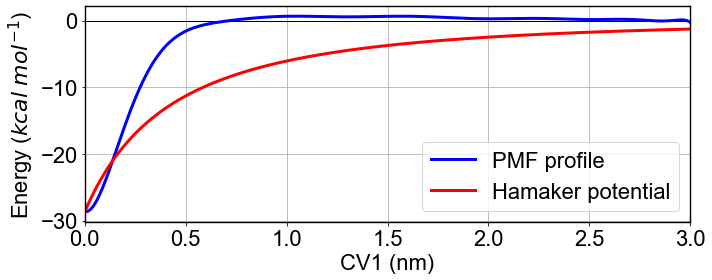

In [27]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
ax.tick_params(labelsize=Z)
ax.grid()
ax.set_xlabel("CV1 (nm)", fontsize=Z)
ax.set_ylabel(r"Energy ($kcal$ $mol^{-1}$)", fontsize=Z)
ax.axhline(0, c='k', lw=1)
ax.plot(cv1, vdw_contribution, c='b', lw=3, label='PMF profile')
ax.plot(cv1, hamaker_cv1(cv1, np_radius=best_radius), lw=3, c='r', label='Hamaker potential')
ax.set_xlim(0,3)
ax.legend(loc='lower right', fontsize=Z)
plt.tight_layout()
#plt.savefig("hamaker.png", format='png', dpi=DPI)
plt.show()
plt.close()

In [28]:
PMFann = []
for np_lab in np_labels:
    pmfann_ion = []
    pmfann_ion_hist = []
    for ion_lab in ion_labels:
        pmfann = read_file("T2/PMF_L_ann/T2-{}-{}_L_PMF.xvg".format(np_lab, ion_lab))
        if np_lab=="N96" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I0":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=16)
        if np_lab=="N104" and ion_lab=="I10":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=12)
        if np_lab=="N104" and ion_lab=="I20":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I50":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=9)
        if np_lab=="N104" and ion_lab=="I90":
            pmfann = clean_pmf(pmfann, X, fit=True, deg_pols=10)
        else:
            pmfann = clean_pmf(pmfann, X, fit=True)
        pmfann_ion.append(pmfann)

    PMFann.append(pmfann_ion)
PMFann = np.array(PMFann)
print(np.shape(PMFann))

C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poor

(14, 6, 200, 2)


C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poorly conditioned
C:\Users\fsebastian\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RankWarning: Polyfit may be poor

In [29]:
PMFann[9,1,:,1] = (PMFann[8,1,:,1]+PMFann[10,1,:,1])/2  #Interpolates N72-I10
PMFann[11,5,:,1] = (PMFann[10,5,:,1]+PMFann[12,5,:,1])/2 #Interpolates N88-I150
#PMFann[12,4,:,1] = (PMFann[11,4,:,1]+PMFann[13,4,:,1])/2 #Interpolates N96-I90

In [30]:
for i in range(len(PMFann)):
    for j in range(len(PMFann[0])):
        PMFann[i,j,:,1] = PMFann[i,j,:,1] - vdw_contribution

# Electrostatic contributions

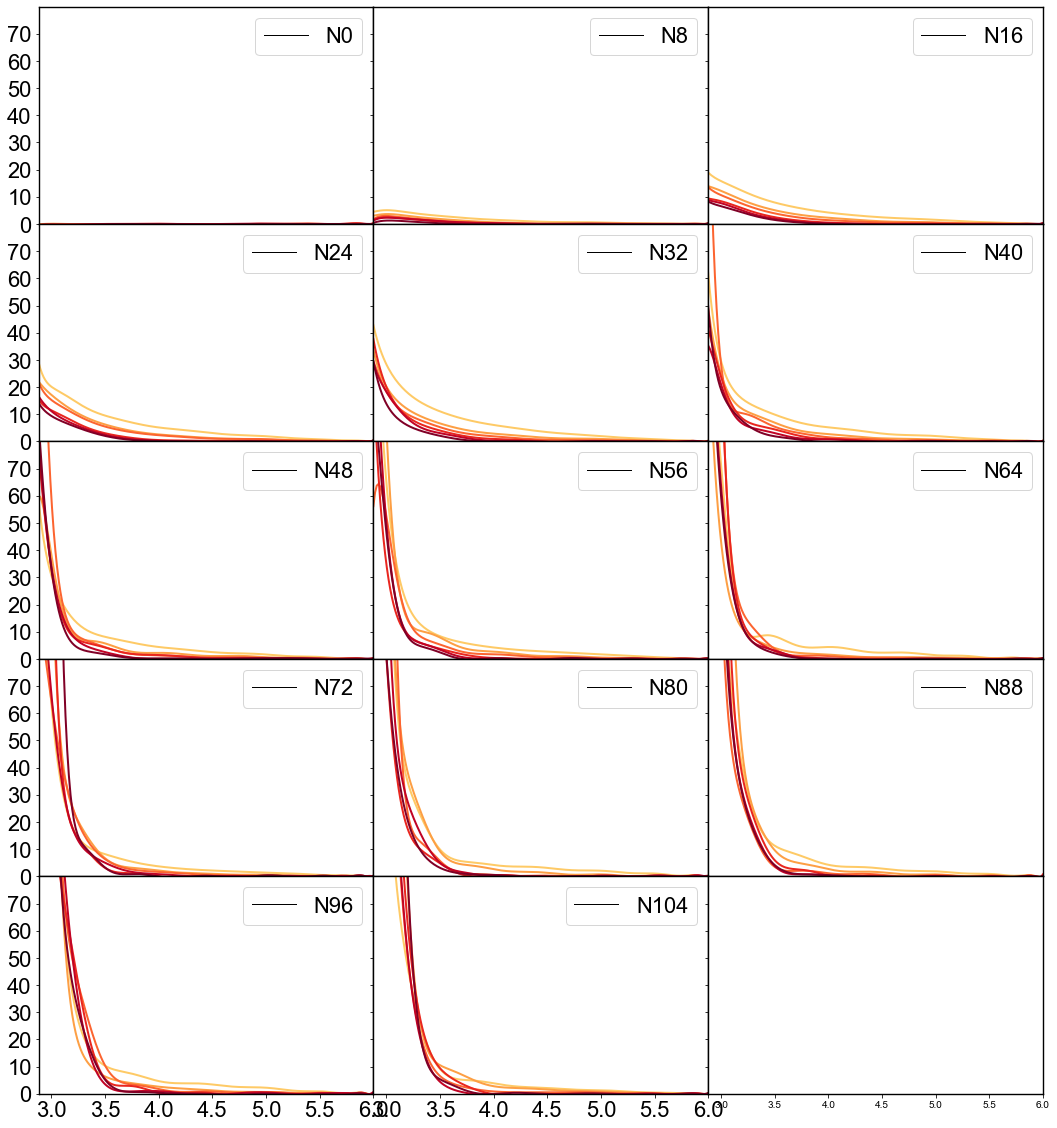

In [31]:
n_cols = 3
n_rows = 5
subplot_kw={'xlim':(Xini, Xfin), 'xticks':np.arange(3,6.1,0.5), 'ylim':(0, 80), 'yticks':np.arange(0, 80, 10)}
gridspec_kw={'hspace':0, 'wspace': 0}
fig, axs = plt.subplots(figsize=(6*n_cols, 4*n_rows), ncols=n_cols, nrows=n_rows, sharey=True, sharex=True, subplot_kw=subplot_kw, gridspec_kw=gridspec_kw)
for ax, PMFs, np_lab in zip(axs.flatten(), PMFann, np_labels):
    ax.tick_params(labelsize=Z)
    ax.axhline(y=0, lw=1, c='k', label=np_lab)
    ax.legend(loc='upper right', fontsize=Z)
    for pmf, c in zip(PMFs, c_ion):
        ax.plot(pmf[:,0], pmf[:,1], color=c, lw=2)
plt.show()
plt.close()

# Free energy maps

In [32]:
zeta_cont = np.loadtxt("contout3mV.csv", delimiter=',')

In [56]:
print(PMFann[3,0,:,0]-2*1.3-0.52)
print(PMFann[3,0,:,1])

[-0.24       -0.22432161 -0.20864322 -0.19296482 -0.17728643 -0.16160804
 -0.14592965 -0.13025126 -0.11457286 -0.09889447 -0.08321608 -0.06753769
 -0.0518593  -0.0361809  -0.02050251 -0.00482412  0.01085427  0.02653266
  0.04221106  0.05788945  0.07356784  0.08924623  0.10492462  0.12060302
  0.13628141  0.1519598   0.16763819  0.18331658  0.19899497  0.21467337
  0.23035176  0.24603015  0.26170854  0.27738693  0.29306533  0.30874372
  0.32442211  0.3401005   0.35577889  0.37145729  0.38713568  0.40281407
  0.41849246  0.43417085  0.44984925  0.46552764  0.48120603  0.49688442
  0.51256281  0.52824121  0.5439196   0.55959799  0.57527638  0.59095477
  0.60663317  0.62231156  0.63798995  0.65366834  0.66934673  0.68502513
  0.70070352  0.71638191  0.7320603   0.74773869  0.76341709  0.77909548
  0.79477387  0.81045226  0.82613065  0.84180905  0.85748744  0.87316583
  0.88884422  0.90452261  0.92020101  0.9358794   0.95155779  0.96723618
  0.98291457  0.99859296  1.01427136  1.02994975  1

In [77]:
def build_dg_map_size(np_radius, n_pts=500):
    #x_start = 2*np_radius+0.28
    #new_X = np.linspace(x_start, x_start+3.12, 200)
    xs = []
    ys = []
    dgs = []
    for i in range(n_ion):
        for j in range(n_np):
            pmf = PMFann[j,i,:,:]*1
            #pmf[:,1] += hamaker_cv1(cv1, np_radius=np_radius)
            #pmf[:,1] += hamaker(new_X, n_density=436, np_radius=np_radius)
            
            ndx = np.argmin(pmf[pmf[:,0]<3.0,1])
            dg_val = pmf[ndx,1] + hamaker_cv1(cv1, np_radius=np_radius)[0]
            print(ion_labels[i], np_labels[j], pmf[ndx,1], hamaker_cv1(cv1, np_radius=np_radius)[0])
            #dg_val = pmf[0,1]
            xs.append(j)
            ys.append(i)
            dgs.append(dg_val)
            
    #interpolation
    rbf = Rbf(xs, ys, dgs, epsilon=2)
    x = np.linspace(0, max(xs), n_pts)
    y = np.linspace(0, max(ys), n_pts)
    X_space, Y_space = np.meshgrid(x,y)
    Z = rbf(X_space, Y_space)
    return X_space, Y_space, Z

I0 N0 0.0 -28.702387791381003
I0 N8 4.47534154355526 -28.702387791381003
I0 N16 16.00115979835391 -28.702387791381003
I0 N24 20.45325868576765 -28.702387791381003
I0 N32 29.33751203585416 -28.702387791381003
I0 N40 31.175748325884342 -28.702387791381003
I0 N48 32.018595822155476 -28.702387791381003
I0 N56 70.51438407227397 -28.702387791381003
I0 N64 76.38228530436754 -28.702387791381003
I0 N72 67.88434163480997 -28.702387791381003
I0 N80 203.96687347441912 -28.702387791381003
I0 N88 128.09616024047136 -28.702387791381003
I0 N96 230.2757662013173 -28.702387791381003
I0 N104 146.830779440701 -28.702387791381003
I10 N0 -0.07134762778878212 -28.702387791381003
I10 N8 3.0534921064972878 -28.702387791381003
I10 N16 12.386745534837246 -28.702387791381003
I10 N24 17.47603894304484 -28.702387791381003
I10 N32 21.019793063867837 -28.702387791381003
I10 N40 26.2213549092412 -28.702387791381003
I10 N48 40.647264428436756 -28.702387791381003
I10 N56 95.43472407013178 -28.702387791381003
I10 N64 47.

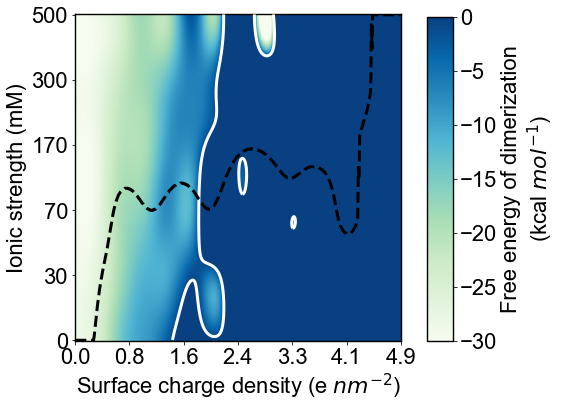

In [78]:
cmap='GnBu'
sx, sy, dg_map = build_dg_map_size(np_radius=best_radius)
fig = plt.figure(figsize=(6,6))
ax = plt.axes()
ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
ax.set_yticklabels(i_vals)
ax.tick_params(labelsize=Z)
ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
ax.contour(dg_map, levels=np.array([-0.593]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
#ax.contour(dg_map, levels=np.array([-5]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

a = plt.axes([0.95, 0.125, 0.06, 0.75])
cbar = fig.colorbar(cax, ax=a, cax=a)#, ticks=[-30, -20, -10, 0, 10])
cbar.ax.tick_params(labelsize=Z)
cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
#plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
plt.show()
plt.close()

In [102]:
dg_atcont = [dg_map[ndx,n] for n, ndx in zeta_cont.astype(int)]

NP radius: 1.3


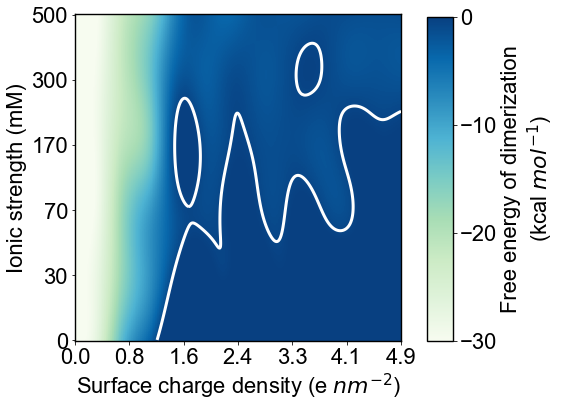

NP radius: 1.5


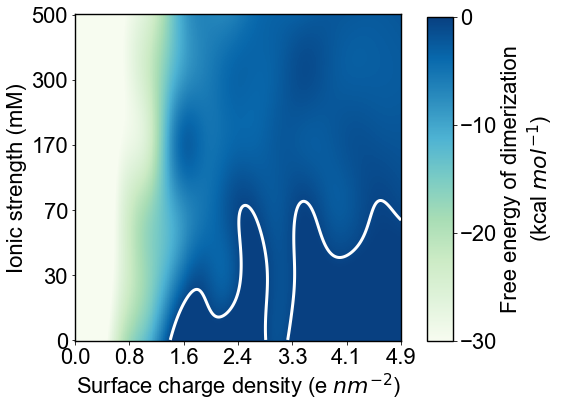

NP radius: 1.7


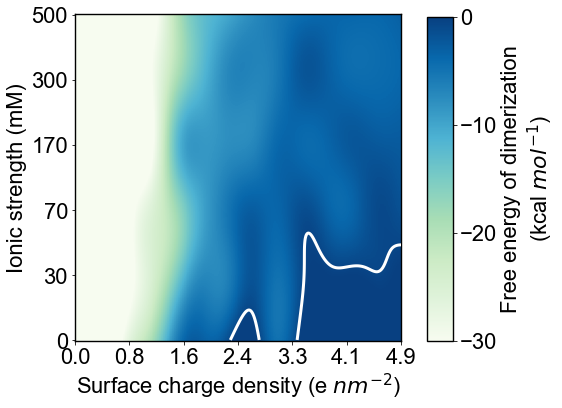

NP radius: 1.9


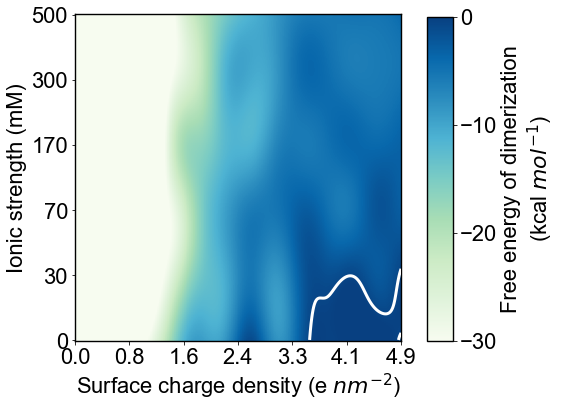

NP radius: 2.1


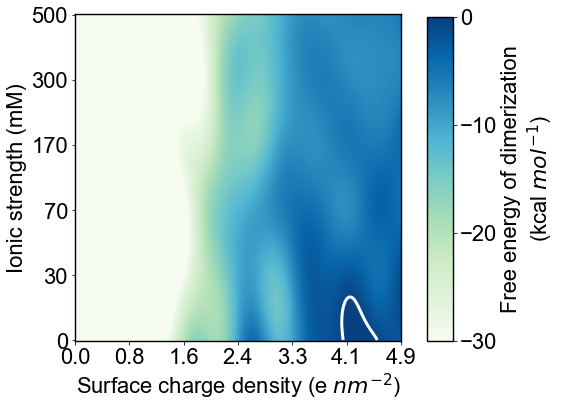

In [103]:
cmap='GnBu'
rs = [1.3, 1.5, 1.7, 1.9, 2.1]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_size(np_radius=r)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
    ax.contour(dg_map, levels=np.array([-0.6]), colors=[(1,1,1)], linewidths=[3], linestyles='solid', zorder=10, origin='lower')
    #ax.plot(zeta_cont[:,0], zeta_cont[:,1], lw=3, c='k', ls='--', zorder=20)

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()

NP radius: 1.3


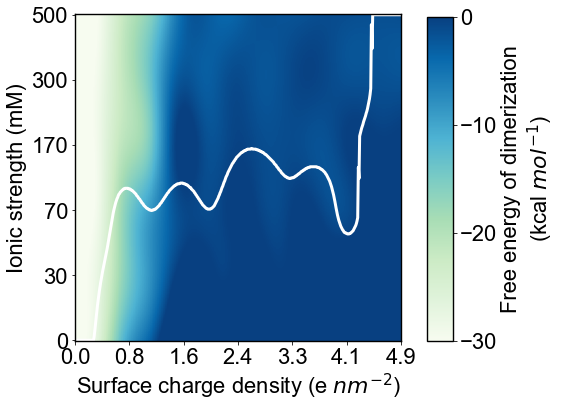

NP radius: 1.5


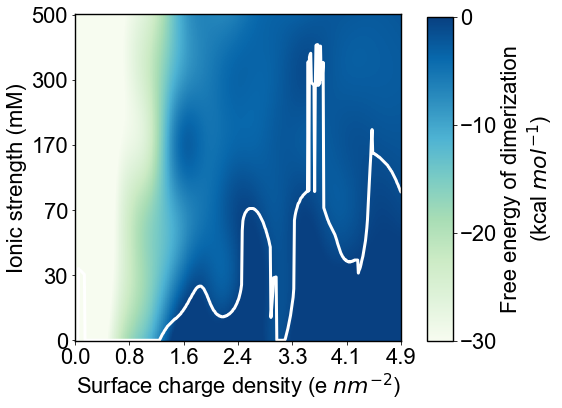

NP radius: 1.7


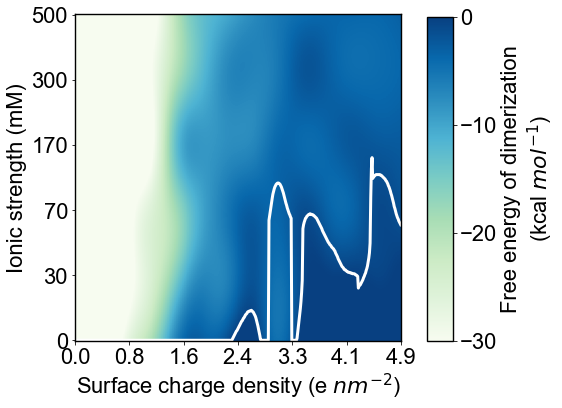

NP radius: 1.9


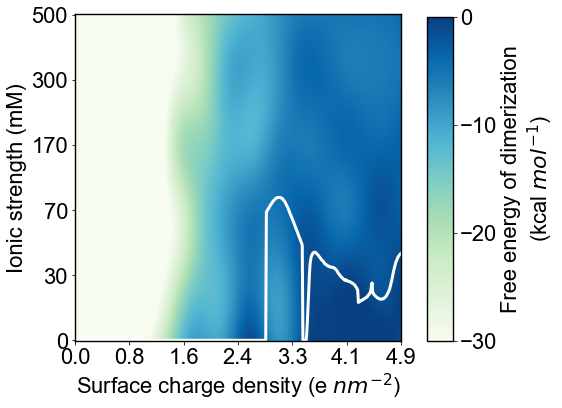

NP radius: 2.1


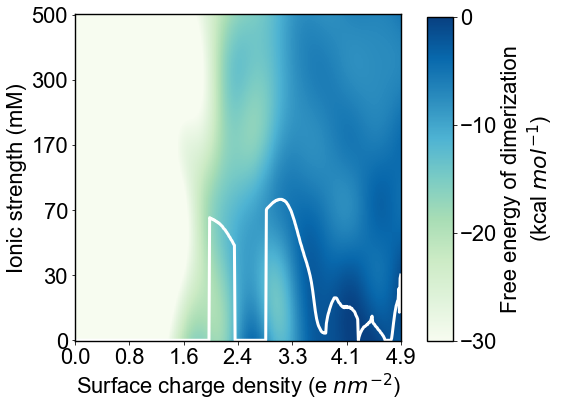

In [104]:
cmap='GnBu'
rs = [1.3, 1.5, 1.7, 1.9, 2.1]
for r in rs:
    print("NP radius: {}".format(r))
    sx, sy, dg_map = build_dg_map_size(np_radius=r)
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes()
    ax.set_xticks(np.linspace(0, len(dg_map)-1, 7))
    ax.set_xticklabels(np.round(np.linspace(min(q_vals), max(q_vals),7), 1))
    ax.set_yticks(np.linspace(0, len(dg_map)-1, n_ion))
    ax.set_yticklabels(i_vals)
    ax.tick_params(labelsize=Z)
    ax.set_xlabel(r"Surface charge density (e $nm^{-2}$)", fontsize=Z)
    ax.set_ylabel("Ionic strength (mM)", fontsize=Z)
    cax = ax.imshow(dg_map, cmap=cmap, origin='lower', vmin=-30, vmax=0)
    cont = []
    for i, (sigma, dg_crit) in enumerate(zip(dg_map.T, dg_atcont)):
        cont.append([i, np.argmin(np.abs(sigma-dg_crit))])
    cont = np.array(cont)
    plt.plot(cont[:,0], cont[:,1], lw=3, c=(1,1,1))

    a = plt.axes([0.95, 0.125, 0.06, 0.75])
    cbar = fig.colorbar(cax, ax=a, cax=a, ticks=[-30, -20, -10, 0, 10])
    cbar.ax.tick_params(labelsize=Z)
    cbar.ax.set_ylabel("Free energy of dimerization\n"+r"(kcal $mol^{-1}$)", fontsize=Z)
    #plt.savefig("PhaseDiagram_Lann.png", format='png', dpi=DPI, bbox_extra_artists=(a,), bbox_inches='tight')
    plt.show()
    plt.close()